In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import kurtosis
# Bibliotecas de modelamiento
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [1]:
def remove_outliers_zscore(df, column, threshold=3):
    """
    Remove rows from a DataFrame where the Z-score of the values in a given column exceeds the threshold.
    
    Parameters:
    df (pd.DataFrame): The DataFrame from which to remove outliers.
    column (str): The name of the column to check for outliers.
    threshold (float): The Z-score threshold for determining outliers. Default is 3.
    
    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    # Calculate the Z-scores
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    
    # Filter the DataFrame to keep only rows where Z-score is below the threshold
    df_filtered = df[z_scores < threshold]
    
    return df_filtered

In [2]:
def cramers_v(var1, var2):
    """Calcula la correlación de Cramér V entre dos variables categóricas."""
    tabla = pd.crosstab(var1, var2)
    chi2, p, dof, expected = chi2_contingency(tabla)
    n = tabla.sum().sum()
    min_dim = min(tabla.shape) - 1
    return np.sqrt((chi2 / n) / min_dim)

def cramer_v_matrix(df):
    """Devuelve un DataFrame con la correlación de Cramér V entre todas las variables categóricas del DataFrame."""
    # Seleccionamos solo las columnas categóricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Creamos un DataFrame vacío para almacenar los valores de correlación
    cramers_v_df = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    
    # Rellenamos la matriz de correlaciones con los valores de Cramér V
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cramers_v_df.loc[col1, col2] = 1.0  # Correlación perfecta consigo misma
            else:
                cramers_v_df.loc[col1, col2] = cramers_v(df[col1], df[col2])
    
    return cramers_v_df

In [5]:
df = pd.read_excel("../trabajo_final/Data Set.xlsx")

In [7]:
df.columns = [i.lower() for i in df.columns]
df["applicant_postal_code"] = df["applicant_postal_code"].astype(str)
df = df.drop(columns=["gender_desc"])

In [9]:
df.head()

,id,requested_amount,emi_amount,age,applicant_postal_code,duration_of_current_emp,product_name1,product_line,loan_term,variant_code,...,no_of_years_in_city,no_of_years_at_business,segment_desc,cost_of_vehicle,average_bank_balance,cibil_score,disbursed,irr,max_od_f_12m,total_ntech_bnc_f12m
0,1,200000,5750.0,40.50,400091.0,5.0,CHEVROLET SPARK,CHEVROLET SPARK LT 1.0 BS-IV OBDII,48.0,LT 1.0 BS-IV OBDII,...,35.0,NaN,Compact,237342.0,NaN,594.0,No,24.70,NaN,NaN
1,2,1900000,NaN,41.25,641002.0,NaN,FORTUNER 4 WD,TOYOTA - FORTUNER 4 WD,48.0,FORTUNER 4 WD,...,1.0,NaN,SUV,2400000.0,NaN,754.0,Yes,24.70,0.0,0.0
2,3,1600000,NaN,39.50,641002.0,NaN,NaN,TOYOTA - FORTUNER 3.0 L,48.0,FORTUNER 3.0 L,...,1.0,NaN,SUV,2200000.0,NaN,779.0,Yes,16.50,0.0,0.0
3,4,300000,9050.0,35.00,390019.0,16.0,NISSAN MICRA,NISSAN MICRA,48.0,NISSAN MICRA XL,...,7.0,NaN,Compact,365750.0,NaN,818.0,Yes,18.10,0.0,0.0
4,5,250000,8750.0,34.00,390023.0,NaN,XYLO E8,XYLO E8,36.0,XYLO E8,...,2.0,NaN,MUV,548750.0,NaN,853.0,Yes,17.69,0.0,1.0


In [10]:
missing_percentage = df.isnull().mean() * 100
columns_with_nulls_above_30 = missing_percentage[missing_percentage > 30].index.tolist()
print(missing_percentage)

id                             0.000000
requested_amount               0.000000
emi_amount                     2.779060
age                            0.000000
applicant_postal_code          0.000000
duration_of_current_emp       76.853476
product_name1                  1.121780
product_line                   0.013849
loan_term                      0.009233
variant_code                   0.013849
manufacturer_desc              0.013849
marital_status_desc           10.820792
applicant_state_desc           0.023082
applicant_city_desc            0.041547
resid_owned_by_desc            1.657280
employment_type_desc           0.004616
total_work_experience         77.130459
application_creation_date      0.000000
ex_showroom_price             12.828917
segment                        1.874250
current valuation             12.865848
years_in_current_business     34.415105
no_of_years_at_residence      12.570400
no_of_years_in_city            1.634198
no_of_years_at_business      100.000000


In [11]:
df_eda = df.drop(columns = columns_with_nulls_above_30)

In [46]:
df_no_outliers = df_eda.copy()
for col in df_eda.drop(columns=["id"]).select_dtypes(include=['float64', 'int64']).columns:
    df_no_outliers = remove_outliers_zscore(df_no_outliers, col, threshold=3)
    print(col, df_no_outliers.shape[0])
df_no_outliers = df_no_outliers.reset_index(drop=True)

requested_amount 21657
emi_amount 20799
age 20709
loan_term 20701
ex_showroom_price 18316
current valuation 18304
no_of_years_at_residence 17907
no_of_years_in_city 17866
cost_of_vehicle 17771
cibil_score 17764
irr 17764


In [47]:
df_no_outliers["disbursed_categorical"] = df_no_outliers["disbursed"]
df_no_outliers["disbursed"] = np.where(df_no_outliers["disbursed"]=="No",0,1)
df_no_outliers_segment = df_no_outliers[df_no_outliers["irr"]>=17]

In [48]:
df_no_outliers_segment["disbursed"].value_counts()

disbursed
0    6304
1    4194
Name: count, dtype: int64

## Numericas

In [49]:
numeric_columns = df_no_outliers_segment.drop(columns=["id"]).select_dtypes(include=['float64', 'int64']).columns

In [50]:
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
requested_amount,21662.0,7.324396e+07,4.968147e+09,72.00,275000.00,405000.00,650000.00,4.630100e+11
emi_amount,21060.0,1.788169e+04,2.401851e+04,0.00,8663.75,12696.00,19800.00,1.379000e+06
age,21662.0,3.909306e+01,1.015490e+01,18.10,31.20,37.58,45.67,8.380000e+01
loan_term,21660.0,4.398015e+01,1.288238e+01,3.00,36.00,36.00,60.00,9.600000e+02
ex_showroom_price,18883.0,6.868931e+05,1.018567e+06,0.00,335440.50,488544.00,744948.50,8.188200e+07
current valuation,18875.0,2.301728e+07,2.583385e+09,1.00,334854.00,487900.00,744372.00,3.470100e+11
no_of_years_at_residence,18939.0,1.393065e+01,1.156783e+01,0.00,5.00,10.00,20.00,6.900000e+01
no_of_years_in_city,21308.0,4.360622e+05,6.365106e+07,0.00,5.00,10.00,20.00,9.291311e+09
cost_of_vehicle,21660.0,7.713597e+05,3.609668e+06,48000.00,350000.00,506730.00,800000.00,5.044863e+08
cibil_score,21654.0,6.062178e+02,3.031745e+02,-1.00,597.00,757.00,796.00,8.970000e+02


requested_amount
emi_amount
age
loan_term
ex_showroom_price
current valuation
no_of_years_at_residence
no_of_years_in_city
cost_of_vehicle
cibil_score
disbursed
irr


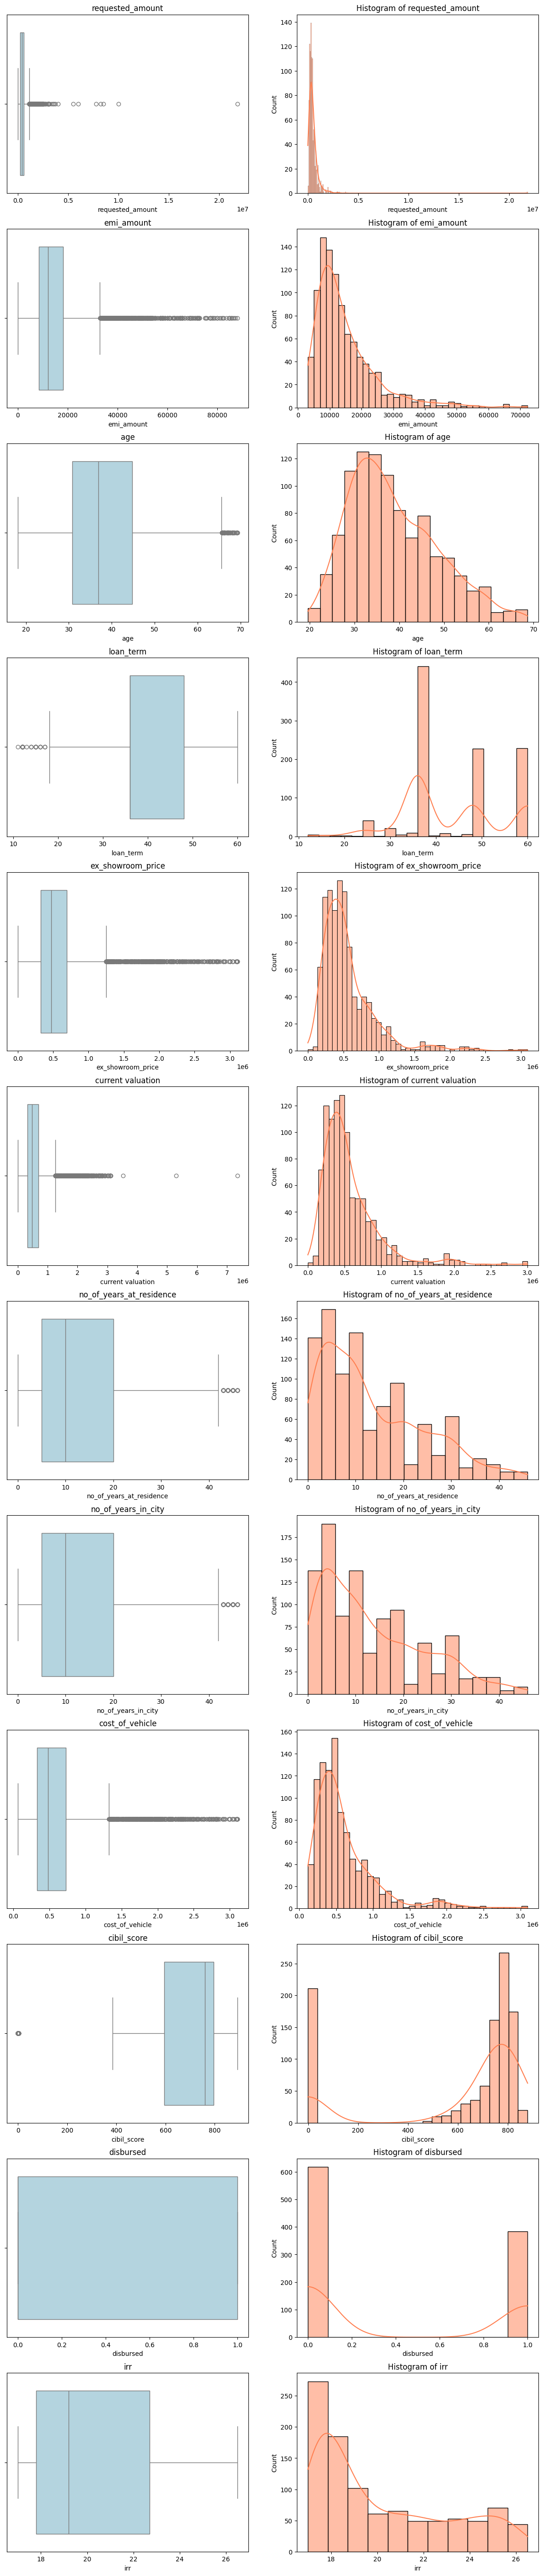

In [51]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, len(numeric_columns)*6))

for i, column in enumerate(numeric_columns, 1):
    print(column)
    # Crear subplots para box plot y histograma
    plt.subplot(len(numeric_columns), 2, 2*i-1)  # Box plot
    sns.boxplot(x=df_no_outliers_segment[column], color='lightblue')
    #kurt_value = kurtosis(df[column].dropna(), nan_policy='omit')
    plt.title(f"{column}")
    
    plt.subplot(len(numeric_columns), 2, 2*i)  # Histograma
    sns.histplot(df_no_outliers_segment[column].sample(1000), kde=True, color='coral')
    plt.title(f"Histogram of {column}")

In [52]:
# Calcular la curtosis para cada columna numérica
kurtosis_values = df_no_outliers_segment[numeric_columns].apply(lambda x: kurtosis(x, nan_policy='omit'))

# Crear un nuevo DataFrame con los valores de la curtosis
kurtosis_df = pd.DataFrame(kurtosis_values, columns=['Kurtosis'])

# Mostrar el DataFrame de curtosis
print(kurtosis_df)

                            Kurtosis
requested_amount          510.574599
emi_amount                  7.969084
age                        -0.193515
loan_term                  -0.827787
ex_showroom_price           8.103600
current valuation          15.638484
no_of_years_at_residence   -0.189970
no_of_years_in_city        -0.240441
cost_of_vehicle             6.529759
cibil_score                -0.155520
disbursed                  -1.831608
irr                        -0.940496


In [53]:
r = df_no_outliers_segment[numeric_columns].corr(method='spearman').round(3)
r

,requested_amount,emi_amount,age,loan_term,ex_showroom_price,current valuation,no_of_years_at_residence,no_of_years_in_city,cost_of_vehicle,cibil_score,disbursed,irr
requested_amount,1.000,0.896,0.104,0.283,0.833,0.828,-0.019,-0.021,0.809,0.090,-0.065,0.028
emi_amount,0.896,1.000,0.131,0.003,0.819,0.815,0.002,0.000,0.795,0.103,-0.037,0.016
age,0.104,0.131,1.000,-0.056,0.063,0.063,0.084,0.080,0.053,0.180,0.039,-0.011
loan_term,0.283,0.003,-0.056,1.000,0.252,0.252,-0.058,-0.056,0.244,-0.025,-0.097,0.041
ex_showroom_price,0.833,0.819,0.063,0.252,1.000,0.984,0.020,0.018,0.962,0.035,-0.054,0.025
current valuation,0.828,0.815,0.063,0.252,0.984,1.000,0.019,0.019,0.956,0.030,-0.054,0.024
no_of_years_at_residence,-0.019,0.002,0.084,-0.058,0.020,0.019,1.000,0.980,0.012,0.009,-0.002,-0.005
no_of_years_in_city,-0.021,0.000,0.080,-0.056,0.018,0.019,0.980,1.000,0.012,0.008,-0.005,-0.003
cost_of_vehicle,0.809,0.795,0.053,0.244,0.962,0.956,0.012,0.012,1.000,0.019,-0.048,0.023
cibil_score,0.090,0.103,0.180,-0.025,0.035,0.030,0.009,0.008,0.019,1.000,0.063,-0.056


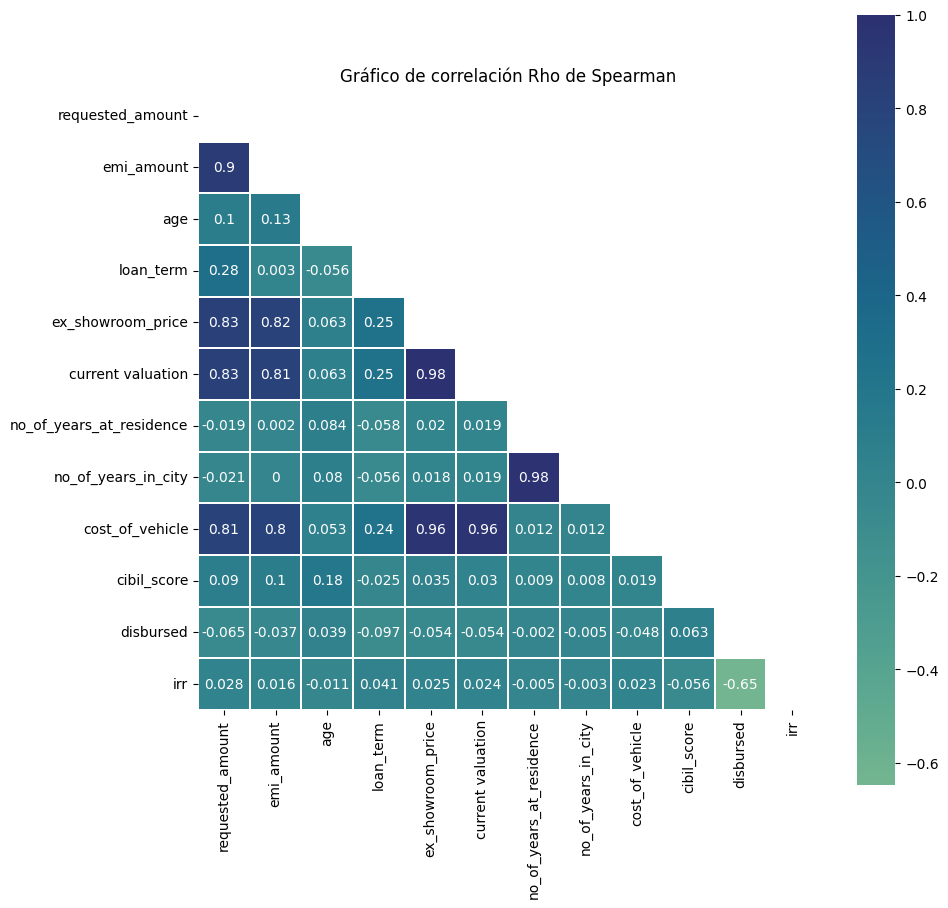

In [54]:
mask = np.triu(np.ones_like(r, dtype=bool )) #la máscara para el triángulo superior del gráfico
f, ax = plt.subplots(figsize = (10,10)) # la base para el gráfico
g = sns.heatmap(r, mask = mask, cmap='crest', vmax=1, center = 0,
            square = True, linewidths=.1, annot=True)

g.set_title("Gráfico de correlación Rho de Spearman");

## Categoricas

In [55]:
object_columns = df_no_outliers_segment.select_dtypes(include=['object']).columns

In [56]:
df_no_outliers.describe(include="object").T

,count,unique,top,freq
applicant_postal_code,17764,2692,132001.0,339
product_name1,17573,312,TOYOTA INNOVA,1331
product_line,17764,1322,TOYOTA INNOVA 2013 2.5 GX 7 STR BS-IV,402
variant_code,17764,1159,VDi,473
manufacturer_desc,17764,30,MARUTI,5169
marital_status_desc,17751,4,Married,16701
applicant_state_desc,17764,28,MAHARASHTRA,3536
applicant_city_desc,17764,343,HYDERABAD,1446
resid_owned_by_desc,17764,8,SELF,11596
employment_type_desc,17764,6,SELF EMPLOYED NON-PROFESSIONAL,12885


In [57]:
correlation_matrix = cramer_v_matrix(df_no_outliers_segment[object_columns])

In [63]:
correlation_matrix

,applicant_postal_code,product_name1,product_line,variant_code,manufacturer_desc,marital_status_desc,applicant_state_desc,applicant_city_desc,resid_owned_by_desc,employment_type_desc,segment,segment_desc,disbursed_categorical
applicant_postal_code,1.0,0.471139,0.472999,0.473805,0.449402,0.562013,0.985067,0.884049,0.484423,0.510092,0.458244,0.458244,0.509702
product_name1,0.471139,1.0,0.981805,0.955572,0.985781,0.137192,0.189513,0.174258,0.188615,0.21118,0.890783,0.890783,0.237004
product_line,0.472999,0.981805,1.0,0.977768,0.995491,0.277229,0.390506,0.349202,0.346978,0.35828,0.911543,0.911543,0.41057
variant_code,0.473805,0.955572,0.977768,1.0,0.978288,0.259769,0.402702,0.336006,0.324011,0.345682,0.879348,0.879348,0.392519
manufacturer_desc,0.449402,0.985781,0.995491,0.978288,1.0,0.05383,0.075681,0.157629,0.073409,0.108597,0.518195,0.518195,0.07168
marital_status_desc,0.562013,0.137192,0.277229,0.259769,0.05383,1.0,0.090489,0.18949,0.073903,0.080058,0.038335,0.038335,0.009858
applicant_state_desc,0.985067,0.189513,0.390506,0.402702,0.075681,0.090489,1.0,0.994864,0.158799,0.112806,0.078898,0.078898,0.190476
applicant_city_desc,0.884049,0.174258,0.349202,0.336006,0.157629,0.18949,0.994864,1.0,0.240565,0.231776,0.173787,0.173787,0.295534
resid_owned_by_desc,0.484423,0.188615,0.346978,0.324011,0.073409,0.073903,0.158799,0.240565,1.0,0.095192,0.035343,0.035343,0.030269
employment_type_desc,0.510092,0.21118,0.35828,0.345682,0.108597,0.080058,0.112806,0.231776,0.095192,1.0,0.093251,0.093251,0.029969


## Numéricas + Categóricas

In [64]:
df_yes_loan = df_no_outliers_segment[df_no_outliers_segment["disbursed"]==1].reset_index(drop=True)
df_group = df_yes_loan.groupby(["irr"]).agg("count")[["id"]].reset_index()
df_group = df_group.rename(columns={"id": "cantidad"})

<Axes: xlabel='irr', ylabel='cantidad'>

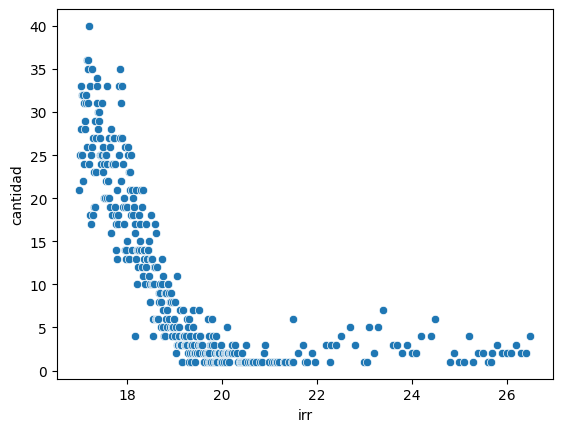

In [65]:
sns.scatterplot(data=df_group, x="irr", y="cantidad")

<Axes: ylabel='irr'>

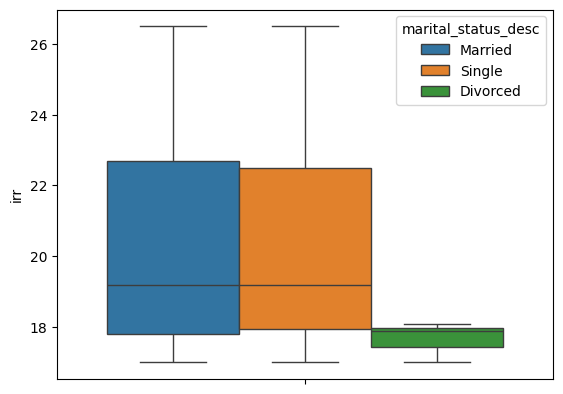

In [66]:
sns.boxplot(data=df_no_outliers_segment, hue="marital_status_desc", y="irr")

<Axes: ylabel='irr'>

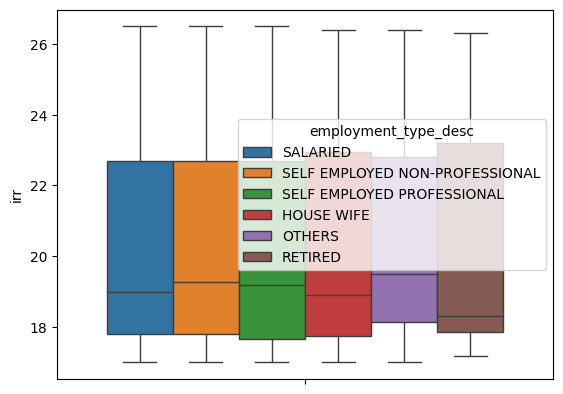

In [67]:
sns.boxplot(data=df_no_outliers_segment, hue="employment_type_desc", y="irr")

<Axes: ylabel='irr'>

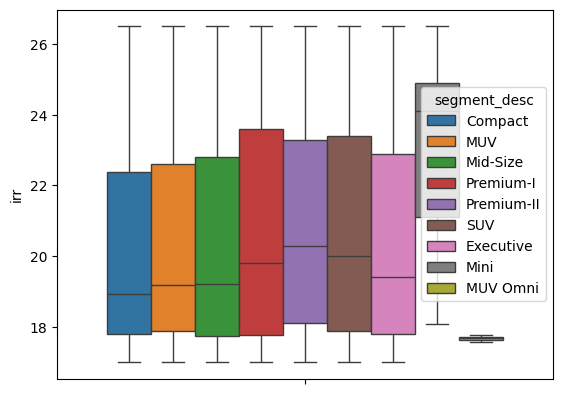

In [68]:
sns.boxplot(data=df_no_outliers_segment, hue="segment_desc", y="irr")

<Axes: ylabel='irr'>

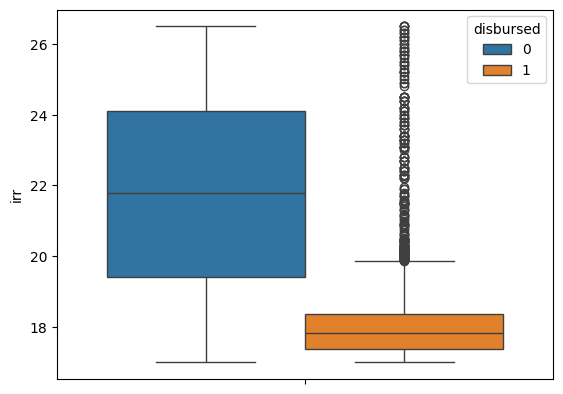

In [69]:
sns.boxplot(data=df_no_outliers_segment, hue="disbursed", y="irr")

<Axes: ylabel='irr'>

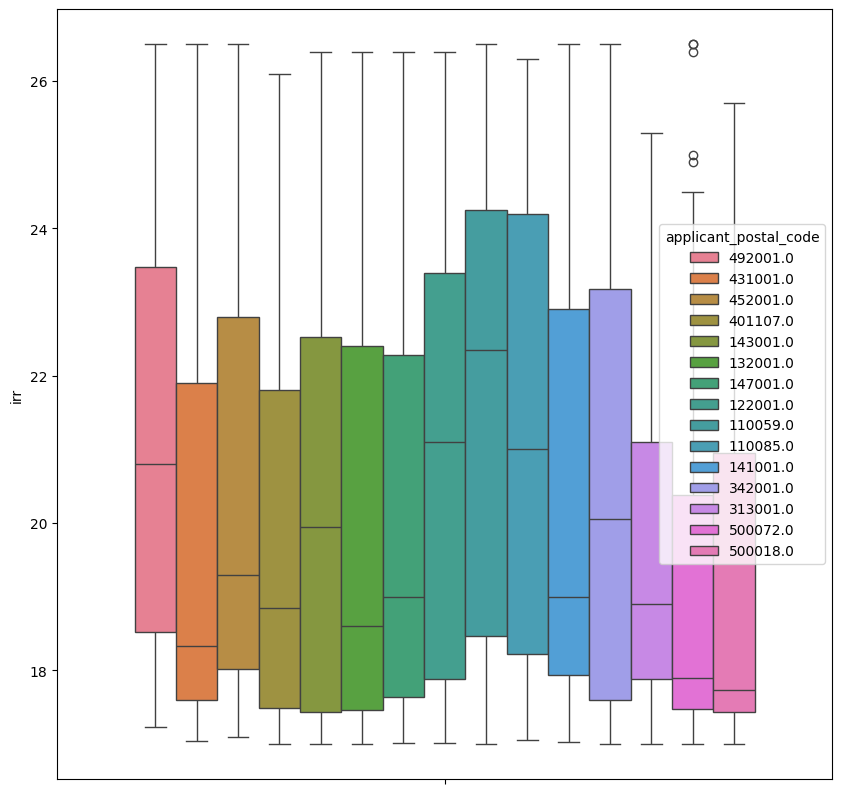

In [70]:
f, ax = plt.subplots(figsize = (10,10)) # la base para el gráfico
sns.boxplot(data=df_no_outliers_segment[df_no_outliers_segment["applicant_postal_code"].isin(df_no_outliers_segment["applicant_postal_code"].value_counts().head(15).index)], hue="applicant_postal_code", y="irr")